In [219]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import pandas as pd  
import numpy as np  

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)


import matplotlib.pyplot as plt
import seaborn as sns

from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates

from scipy.optimize import minimize

import warnings

# from QUANTAXIS.QAUtil import DATABASE
# from QUANTAXIS.QAUtil import  trade_date_sse
# from QUANTAXIS.QAUtil.QADate_trade import (
#     QA_util_get_pre_trade_date,
#     QA_util_get_next_trade_date,
#     QA_util_if_tradetime
# )

# import inspect

# from sklearn import linear_model

# %load_ext autoreload
# %autoreload 2
# %aimport ind.alpha191

In [329]:
###加载数据
data = load_cache('base10_train',cache_type=CACHE_TYPE.FACTOR)
data.dropna(subset=['resvol'], inplace=True)

In [3]:
def nan_count(x):
    return round(x.isna().sum(axis=0)/len(x),4)*100

def filter_invalid_factor(fators_df):
    ## 缺失30%以上，且3倍方差以上，废弃
    ## 加极端判断是为了保证留下那种大窗口期的因子。
    
    fators = fators_df.replace([np.inf, -np.inf], np.nan)
    
    #计算缺失率
    valid_rate = excute_for_multidates(fators, nan_count, level=1) 
    valid_distribute_boundary = valid_rate.mean(axis=0) + valid_rate.std(axis=0)*3
    #缺失率符合当前因子在所有标的上，符合3个标准差的
    filter_contition = valid_rate > valid_distribute_boundary 
    
    def filter_invalid(x):
        code = x.index.get_level_values(1)[0]
        distribute_condition = filter_contition.loc[code] 
        #符合3个标准差的列
        invalid_factors_name = distribute_condition[distribute_condition==True].index 
        #符合3个标准差，并且缺失30%以上的列
        thredhold_condition = valid_rate.loc[code][invalid_factors_name]>30 
        x[thredhold_condition.index] = np.nan 
        return x

    filtered = excute_for_multidates(fators, filter_invalid, level=1)
    
    return filtered

factors_filtered = filter_invalid_factor(data)

In [4]:
def filter_correlative_factor(fators_df, thredhold=.70, show_chart=False,verbose=False):
    #去掉相关性强的因子，相关性大于thredhold的因子（列）将被去除
    corr = fators_df.corr()
    matrix = corr.values
    #取得下三角矩阵
    matrix[np.triu_indices(matrix.shape[0])]=np.nan
    corr_triu = pd.DataFrame(matrix, columns=corr.columns, index=corr.index)

    if show_chart:
        plt.figure(figsize=(30,30))
        labels = corr.columns #.str.replace('191_alpha','')
        ax = sns.heatmap(corr_triu, xticklabels=labels, yticklabels=labels, cmap="YlGnBu",cbar=True)

    # 取得符合条件的因子对后，再取“一对的左边”作为删除目标
    correlative_columns_name = corr_triu.abs().gt(thredhold).stack().loc[lambda x: x].index.get_level_values(0).unique().to_list()
    
    if verbose:
        print('delete correlative factors: {}'.format(','.join(correlative_columns_name)))
        
    correlative_droed = fators_df.drop(columns=correlative_columns_name)
    return correlative_droed

factors_filtered = filter_correlative_factor(factors_filtered,show_chart=False,verbose=True)

delete correlative factors: 


In [5]:

# VIF(data)

###！！标准化不能用全数据做，会报带来未来数据，只能再截面内做
##标准化
# fenlei = factors_filtered.nunique()
# rows_count = factors_filtered.shape[0]
# if rows_count > 1000:
#     thredhold = rows_count *0.01
# else:
#     thredhold = 10
# is_label = fenlei<thredhold
# is_not_label = factors_filtered.columns.difference(is_label[is_label].index,sort=False)
# is_not_label_factors = factors_filtered[is_not_label]
# factors_filtered[is_not_label] = (is_not_label_factors-is_not_label_factors.mean(axis=0,skipna=True))/  is_not_label_factors.std(axis=0,skipna=True)


In [80]:
# with pd.option_context("display.max_rows", None, "display.max_columns", None):

# factors = factors_filtered.iloc[:,0:112]# .loc[['2019-12-25']]
factors = factors_filtered

codes = factors.index.get_level_values(1).unique()
dates = factors.index.get_level_values(0).unique()
data_replenish = load_cache_adv('all_train_qfq',
                                dates.min().strftime('%Y-%m-%d'),
                                dates.max().strftime('%Y-%m-%d'),
                                cache_type=CACHE_TYPE.STOCK).sort_index()

ret = smpl.get_forward_return(data_replenish,'close')
ret.name = 'ret'
ret[np.abs(ret)>0.15]=np.nan

industy = data_replenish['industry']
cap = data_replenish['market_value']


# factors = factors.assign(cap=cap,industry = industy)
factors = factors.assign(country=1.0, cap=cap,industry = industy)
factors = pd.get_dummies(factors,'industry')

## 国家因子换到第一列
columns_ = factors.columns.to_list()
columns_.insert(0,columns_.pop(columns_.index('country')))
factors = factors.reindex(columns=columns_)



# adj_weight = np.sqrt(cap)/np.sqrt(cap).sum()
# adj_weight_mat = pd.DataFrame(np.diag(adj_weight),index=adj_weight.index, columns=adj_weight.index)

# del factors['country']


In [127]:


def multi_factors_model(factors_df,ret_series, model_confirm=False):
    #排除回报全空的情况
    # print(ret_series.index[0])
    if ret_series.isna().all():
        tmp = pd.Series(np.full(factors_df.shape[1],np.nan),index=factors_df.columns)
        fas_names = factors_df.columns.difference(
        ['cap']+
        factors_df.columns[factors_df.columns.str.contains('industry_')].to_list()
        )
        return tmp[fas_names],tmp[tmp.index.str.contains('industry_')]
    
    ##factors_df 为单日，或多日混合，无date index。
    _invalid_check = nan_count(factors_df)
    ## 去除缺失5%以上的因子
    drop_columns = _invalid_check[_invalid_check>5].index
    if len(drop_columns) != 0:
        warnings.warn('以下因子缺失超过5%：{}'.format(','.join(drop_columns)))
    _invalid_checked = factors_df.drop(columns=drop_columns)
    
                      
    # 去除仍有少量缺失的标的
    _invalid_checked = _invalid_checked.dropna()


    ##  防止回报中有nan，
    ## 因为1.使用T-1的因子对T的回报;2.停牌重组之类复权失败的。所以有可能出现这种情况
    ret_nan_flag = ret_series.isna()
    if ret_nan_flag.any():
        ret_nan_index = ret_series[ret_nan_flag].index
        ret_ = ret_series.drop(index=ret_nan_index)
        for index in ret_nan_index:
            if index in _invalid_checked.index:
                _invalid_checked = _invalid_checked.drop(index=ret_nan_index)
    else:
        ret_ = ret_series
    ## 去除内容全部相同的列
    exclude_all_same_cond = (_invalid_checked != _invalid_checked.iloc[0]).any()
    if 'country' in exclude_all_same_cond.index:
        exclude_all_same_cond['country'] = True
    _invalid_checked = _invalid_checked.loc[:, exclude_all_same_cond]

  
        
    ## 去除内容列后，从新计算剩余的行业数量
    industy_count = _invalid_checked.columns.str.contains('industry_').sum()

    _cap=_invalid_checked['cap']

    #计算个股权重矩阵
    ##个股权重矩阵，权重为流通市值平方占比
    cap_temp = np.sqrt(_cap)
    wight = cap_temp/cap_temp.sum()
    V = np.diag(wight) #pd.DataFrame(np.diag(wight),columns = _cap.index,index = _cap.index)

    _industy_dummy = _invalid_checked.iloc[:,-1*industy_count:]
    industry_cap = _cap.T.dot(_industy_dummy)
    industry_wight = industry_cap/industry_cap.sum()  
    
    #风格因子标准化
    factors_columns = _invalid_checked.columns.difference(
        ['cap','country']+
        _invalid_checked.columns[_invalid_checked.columns.str.contains('industry_')].to_list()
        ,sort=False
        )
    
    _invalid_checked[factors_columns] = (
        _invalid_checked[factors_columns] - _invalid_checked[factors_columns].mean(axis=0,skipna=True)
        ) / _invalid_checked[factors_columns].std(axis=0,skipna=True)
    #=========================基础处理结束

    X = _invalid_checked[_invalid_checked.columns.difference(['cap'],sort=False)]
    Y = ret_[X.index]

    ##计算约束矩阵防止共线性问题
    #构建约束矩阵R，R为K*K-1矩阵，K为因子数量
    #将最后一个行业因子表示为其他行业的线性形式
    #移除最后一个行业所在的列，并对其所在的行进行权重处理
    k = X.shape[1] #总因子数量
    p = industy_count #行业因子数量
    # q = k-1-p #风格因子数量
    q = k-p #原风格因子数量

    diag_R = np.diag(np.ones(k))
    location = q
    R = np.delete(diag_R,location+p-1,axis = 1)
    adj_industry_weights = -industry_wight.div(industry_wight[-1]).iloc[:-1]
    R[location+p-1,location:location+p] = adj_industry_weights


    # showR = pd.DataFrame(R,columns=np.delete(X.columns,location+p-1),index=X.columns)
    # with pd.option_context("display.max_rows", None, "display.max_columns", None):
    #     display(showR)
    # showR.to_excel('./showR.xlsx')

    
    #求解投资组合股票权重矩阵
    W = R.dot(np.linalg.inv(np.array(R.T.dot(X.T).dot(V).dot(X).dot(R),dtype='float'))).dot(R.T).dot(X.T).dot(V)
    W = pd.DataFrame(W,index = X.columns,columns = X.index)#.round(6)
 
    
    #计算因子收益率
    f = W.dot(Y).T
    if model_confirm:
        with pd.option_context("display.max_rows", None, "display.max_columns", None):
            display(W.dot(X).round(4))
    residual = Y - X.dot(f.T)
    residual.name='residual'
    # residual.sum()
    # return f, W, residual
    if f.isna().any():
        print(factors_df.index.get_level_values(0)[0],f[0])
        
    return f[['country']+factors_columns.to_list()], f[f.index.str.contains('industry_')]

# d='2019-04-29'
# removed = factors.columns.difference(['alpha','residual'],sort=False)
# re = multi_factors_model(factors.loc[d][removed],ret.loc[d], model_confirm=False)
# re

# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(round(pd.concat([re[2],ret.loc[d]],axis=1),4))

# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(factors.loc[''][removed].isna().any())


In [132]:
test_index = factors.index.get_level_values(0).unique().to_list()
removed = factors.columns.difference(['alpha','residual'],sort=False)
x=list(map(lambda x:multi_factors_model(factors.loc[str(x)][removed],ret.loc[str(x)], model_confirm=False), test_index))
fa_f,indu_f=zip(*x)

fa_f_df = pd.DataFrame(fa_f).cumsum()
indu_f_df = pd.DataFrame(indu_f).cumsum()

fa_f_df.index=test_index
indu_f_df.index=test_index



<AxesSubplot:>

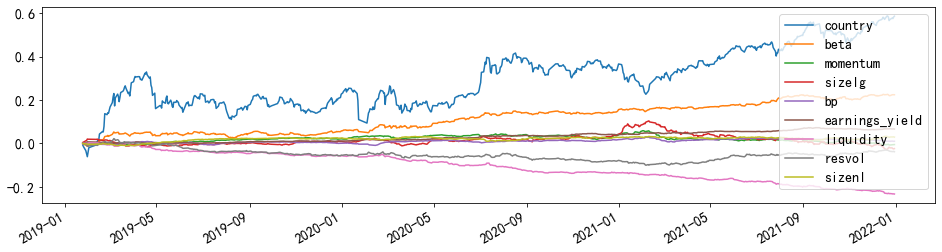

In [129]:
fa_f_df.plot(figsize=(16, 4))


<AxesSubplot:>

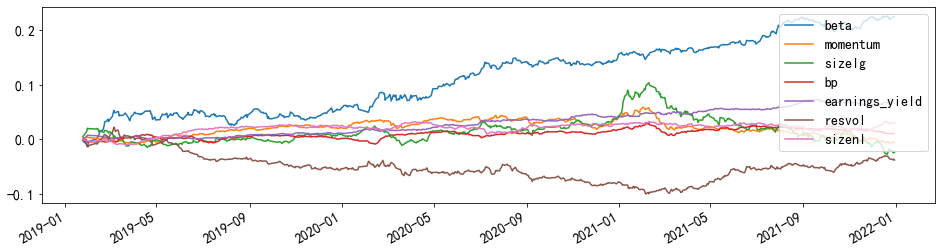

In [130]:
fa_f_df[fa_f_df.columns.difference(['country','liquidity'],sort=False)].plot(figsize=(16, 4))

In [190]:
# smpl.get_codes_from_blockname('航运')
# smpl.get_stock_name(smpl.get_codes_from_blockname('航运'))


In [218]:
# indu_f_df.loc[:,'industry_电信运营服务']
# indu_f_df.loc[('2021-12-30',slice(None))].sort_values()[130:180]
# smpl.get_codes_from_blockname('电信运营服务')

# ['000408', '000792', '000893']
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     print(indu_f_df.loc[(slice(None),),'industry_钾肥']>1)
# 


In [ ]:
# d =  pd.DataFrame(fa_f)['earnings_yield'].iloc[-250:]
# bars = d.plot(figsize=(16, 4),kind='bar',color=(d > 0).map({True:'g', False:'r'}))

In [ ]:
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(f)

def factor_test(date_):
    ## 外部 factors，ret
    test_factor = factors.loc[date_]
    test_ret = ret.loc[date_]

    residual = multi_factors_model(test_factor,test_ret)

    retcurrent_index = retindex_all.index(pd.Timestamp(date_))
    retdate_range = retindex_all[retcurrent_index+1:retcurrent_index+4]
    
    
    return pd.DataFrame(residual)
    # residual_df = pd.DataFrame(residual.abs())
    # try:
    #     residual_df['ret3'] = residual_df.apply(lambda x:ret.loc[(retdate_range,x.name)].sum(),axis=1)
    # except Exception as e:
    #     print(date_,e.__class__.__name__,e)
    #     # traceback.print_exc()
    #     return None
    # return residual_df.sort_values(by='residual',axis='index', ascending=False)['ret3']
    


# date_start = '2019-01-07'
# step = 1
# retindex_all = ret.index.get_level_values(0).unique().to_list()[0::step]
# factors_date_all = factors.index.get_level_values(0).unique().to_list()[0::step]

# test_date_index = factors_date_all.index(pd.Timestamp(date_start))
# test_date_range = factors_date_all[test_date_index+1:test_date_index+int(710/step-1)] #710
# # test_date_range


# # res_cum_pos = pd.Series(0,index=factors.index.get_level_values(1).unique())
# # res_cum_neg = pd.Series(0,index=factors.index.get_level_values(1).unique())
# res_cum = []
# for date_ in test_date_range:
#     res = factor_test(date_)
#     if not res is None:
#     #     res_ = res.dropna()
#     #     topN = res_[0:1]
#     #     tailN = res_[-1:]
#     #     res_cum_pos[topN.index] = res_cum_pos[topN.index]+topN
#     #     res_cum_neg[tailN.index] = res_cum_neg[tailN.index]+tailN
#         res_ = res.dropna()
#         res_cum.append(res_.mean())
#         if res_.mean().abs()[0] > 1:
#             print(date_,res_.mean())
# # print(np.sum(pos),np.sum(neg))


In [78]:
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
# #     # display(X.dot(f.T))
# #     # display(residual.sort_values(ascending=1))
#     display(res_cum)

# res_cum_pos.mean(),res_cum_neg.mean()

a=np.array(res_cum).reshape(-1)
a.sort()
print(a.mean(), a.std()) #0.007843376600751448 0.6770983120962308

0.005935451783332656 0.2086955443641455


In [29]:
# 特定风格因子的预期暴露度最大化

def style_factors_weight_model(factors_df,ret_series):
    ##factors_df 为单日，或多日混合，无date index。
    _invalid_check = nan_count(factors_df)
    ## 去除缺失5%以上的因子
    _invalid_checked = factors_df.drop(columns=_invalid_check[_invalid_check>5].index)
#     ## 去除仍有少量缺失的标的
    _invalid_checked = _invalid_checked.dropna()
    ## 去除内容全部相同的列    
    _invalid_checked = _invalid_checked.loc[:, (_invalid_checked != _invalid_checked.iloc[0]).any()]
    ## 如果有国家因子需要加回来
    if 'country' in factors_df.columns:
        _invalid_checked = _invalid_checked.assign(country=1.0)
        ## 国家因子换到第一列
        _columns = _invalid_checked.columns.to_list()
        _columns.insert(0,_columns.pop(_columns.index('country')))
        _invalid_checked = _invalid_checked.reindex(columns=_columns)
#     ## 去除内容列后，从新计算剩余的行业数量
    industy_count = _invalid_checked.columns.str.contains('industry_').sum()
    _cap=_invalid_checked['cap']

#     #计算个股权重矩阵
#     ##个股权重矩阵，权重为流通市值平方占比
    # cap_temp = np.sqrt(_cap)
    # wight = cap_temp/cap_temp.sum()
    # V = np.diag(wight) #pd.DataFrame(np.diag(wight),columns = _cap.index,index = _cap.index)

    _industy_dummy = _invalid_checked.iloc[:,-1*industy_count:]
    industry_cap = _cap.T.dot(_industy_dummy)
    industry_wight = industry_cap/industry_cap.sum()
    #=========================基础处理结束

    def w_style_func(w, X, style_loc=1):
        '''
        w: 求解的最优权重[w1, w2, ..., wn]^T
        X: 投资组合个股风格因子暴露度矩阵
        H: 投资组合个股行业因子哑变量矩阵
        '''
        return -np.dot(w, X[:, style_loc])


    
    # print(_invalid_checked.columns)
    X = _invalid_checked[_invalid_checked.columns.difference(['cap'],sort=False)]
    X = X.iloc[:,1:-1*industy_count] # 表示N只股票的风格因子暴露度矩阵
    
    # with pd.option_context("display.max_rows", None, "display.max_columns", None):
    #     display(X)
    # print(X)
    
    Xs = X.values
    H = _industy_dummy.values # 表示N只股票的行业因子哑变量矩阵
    h = industry_wight.values # 表示基准指数对应的行业权重，与所选取的参照基准有关
    
    # print(h)
    # print(X.shape)
    # print(np.average(ret_series[X.index]))
    
    num = X.shape[0]                   # 股票数目
    w_ = np.random.random_sample(num)    # 生成介于[0, 1]之间的随机数
    init_w = w_ / w_.sum()               # 随机初始化权重值
    bnds = ((0, 1), ) * num       # 权重限定位于[0, 1]之间
    res_lst = []
    for loc in range(Xs.shape[1]):
        print('-->', loc, X.columns[loc])
        X_ = np.delete(Xs, loc, axis=1)
        cons = (
            {'type': 'eq', 'fun': lambda w: np.dot(w, X_)},            # 数值为0的向量，向量长度等于风格因子数目减1
            {'type': 'eq', 'fun': lambda w: np.dot(w, Xs[:, loc]) - 1}, # 对本身的风格暴露度限定为1
            {'type': 'eq', 'fun': lambda w: np.dot(w, H) - h},          # 对行业因子暴露度与基准一致，由于不能做空，所以无法确保暴露度为0
            {'type': 'eq', 'fun': lambda w: sum(w)-1},                 # 不支持卖空，所以权重之和等于1，其中权重大于0的约束放在参数bounds里面
            )  

        res = minimize(w_style_func, x0=init_w, args=(Xs, loc), constraints=cons, bounds=bnds, method='SLSQP', options={'disp': True,'maxiter':50,'ftol':1e-9})
        # res = minimize(w_style_func, x0=init_w, args=(Xs, loc), constraints=cons, method='COBYLA', options={'disp': True,'maxiter':100})
        print(np.dot(res.x,ret_series[X.index]))
        res_lst.append(res.x)
        # if loc==5:break
    return np.vstack(res_lst)

d='2021-12-08'

rex = style_factors_weight_model(factors.loc[d],ret.loc[d])
rex


--> 0 beta
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1.0115411970229227
            Iterations: 1
            Function evaluations: 2734
            Gradient evaluations: 1
0.011608522236404727
--> 1 alpha
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -0.001963826943904708
            Iterations: 4
            Function evaluations: 10936
            Gradient evaluations: 4
0.013518377360439163
--> 2 residual
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -0.026877522048503015
            Iterations: 3
            Function evaluations: 8202
            Gradient evaluations: 3
0.03818497138996895
--> 3 momentum
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -0.0030606777858703756
            Iterations: 2
            Function evaluations: 5468
            Gradient evaluations: 2
0.011577303422094475
--> 4 sizelg
Ine

array([[7.34947176e-04, 5.80289093e-04, 9.34679506e-05, ...,
        5.83132432e-04, 4.39840404e-04, 3.32654888e-04],
       [7.87924587e-12, 8.63346894e-12, 0.00000000e+00, ...,
        0.00000000e+00, 1.29322291e-12, 9.70684253e-13],
       [0.00000000e+00, 1.42161454e-12, 0.00000000e+00, ...,
        6.80139376e-13, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.34947176e-04, 5.80289093e-04, 9.34679506e-05, ...,
        5.83132432e-04, 4.39840404e-04, 3.32654888e-04],
       [2.23558173e-12, 9.96535835e-13, 3.51102746e-14, ...,
        2.86551219e-13, 1.21962531e-12, 0.00000000e+00],
       [1.79333826e-12, 3.89589424e-12, 3.28748259e-13, ...,
        0.00000000e+00, 0.00000000e+00, 3.48782689e-13]])

In [53]:
# re.index.get_level_values(1).unique()
factors.columns

Index(['country', '191_alpha001', '191_alpha002', '191_alpha003',
       '191_alpha004', '191_alpha005', '191_alpha006', '191_alpha007',
       '191_alpha009', '191_alpha010',
       ...
       'industry_铜', 'industry_铝', 'industry_锂', 'industry_锂电池',
       'industry_防水材料', 'industry_集成电路设计', 'industry_面板', 'industry_风力发电',
       'industry_风电整机', 'industry_黄金'],
      dtype='object', length=232)

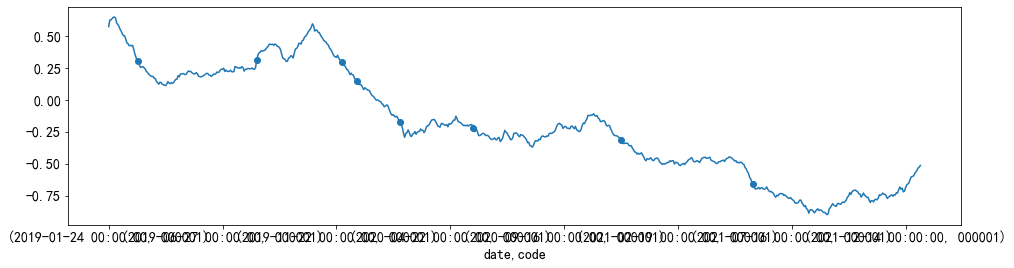

In [434]:
tst = data.loc[(slice(None),'000001'),'liquidity']#.iloc[0:300]
tst.plot(figsize=(16, 4))
change=[ 26, 130, 205, 218, 256, 320, 450, 566]
plt.scatter(change,tst.iloc[change])

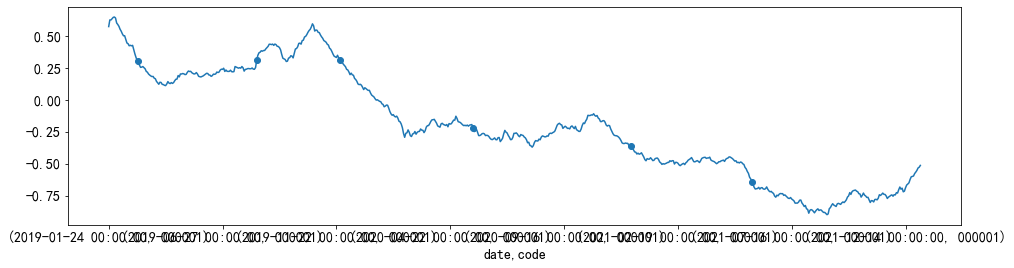

In [435]:
tst.plot(figsize=(16, 4))
change=[26, 130, 203, 320, 459, 565]
plt.scatter(change,tst.iloc[change])

In [414]:
def centered_cusum(data):
    '''
        :param data：{pd.Series|list}        
        :return D_k: {pd.Series|list}  -- the centerd and normalised cumulative sums
    '''
    squared = data**2
    C_k = np.cumsum(data**2)
    C_T = C_k[-1]
    T = len(data)
    ks = np.arange(1, T+1)
    
    D_k = C_k/C_T - (ks/T)
    return D_k

def check_critical(D_k, D_star=1.358):
    ''' Check if the max value of a range exceeds the critcal
        Check if M over the range of D_k exceeds D_star (default: 1.358), 
        if so, it is at -position-
        :param D_k：{pd.Series|list}    
        :param position：{int}    
    ''' 
    D_k_ab = np.abs(D_k)
    max_value = np.max(D_k_ab);
    position = np.argmax(D_k_ab);
    M = (np.sqrt(float(len(D_k))/2.0) * max_value);
    if M > D_star:
        return position
    return None

 
def ICSS_step_1_and_2(data):
    critical_pos_center = check_critical(centered_cusum(data))

    if critical_pos_center is None:
        return None
    pos_left = critical_pos_center
    critical_pos_left_fin = critical_pos_center
    while pos_left:
        critical_pos_left_fin = pos_left
        D_k_left = centered_cusum(data[0:pos_left]);
        pos_left = check_critical(D_k_left);

    pos_right = critical_pos_center
    critical_pos_right_fin = critical_pos_center
    while pos_right:
        critical_pos_right_fin = pos_right
        D_k_right = centered_cusum(data[pos_right:])
        pos = check_critical(D_k_right)
        pos_right =  pos + pos_right if (pos!=0 and pos!=None) else None
    if critical_pos_left_fin==critical_pos_right_fin:
        return critical_pos_left_fin
        
    return critical_pos_left_fin,critical_pos_right_fin

def is_converged(old, new, difference=2):
    '''
        Check if two sets of changepoints are converged
        The two sets are converged if they are of the same length and,
        if each element in the two sets are no more than 'difference' 
        fom the other apart
        :param old：{list|pd.Series}
        :param new：{list|pd.Series}
        :param difference：{int}  --default:2

    '''    
    if len(old) != len(new):
        return False
    
    for i in range(len(new)):
        if abs(old[i]-new[i]) > difference:
            return False
        
    return True


# ICSS_step_1_and_2(tst)

In [432]:
def ICSS(data):
    '''
        参考论文 <<Use of Cumulative Sums of Squares for Retrospective Detection
       of Changes of Variance>>, by [Inclan and Tiao, 1994]
    '''
    # Keep a stack of sub ranges to be inspected for change points
    range_stack = []
    range_stack.append([0, len(data)])
    
    potential_change_points = []
    
    # As long as there are values in the ranges stack, check for sub segments
    while len(range_stack)>0:
        current_range = range_stack.pop();
        print(current_range)
        change_points_sub = ICSS_step_1_and_2(data[current_range[0]:current_range[1]]);
        
        if not change_points_sub is None:
            # Multiple change points found, so put on the stack to inspect next
            if len(change_points_sub)==2:
                ran = [x+current_range[0] for x in change_points_sub]
                range_stack.append(ran);
                potential_change_points.extend(ran)
            else:
                potential_change_points.append(change_points_sub)
    
    # All potential segments/chang-points are found, now check for realchange points
    potential_change_points = [0] + potential_change_points + [len(data)-1]
    potential_change_points = list(set(potential_change_points))
    potential_change_points.sort()
    print('first:',potential_change_points)
    
    # Step 3: check each potential change point
    converged = False;
    while not converged:
        # Store the new retrieved change points of this loop
        new_positions = []

        #check every potential change point by inspecting start and to the surrounding change points
        for i in range(1,len(potential_change_points)-1):
            start = potential_change_points[i-1] + 1;
            to = potential_change_points[i+1];

            # Calculate the Dk and M again for this section of the data
            D_k = centered_cusum(data[start:to]);
            position = check_critical(D_k);

            if position:
                # Keep this (new) change point
                new_positions.append(start+position)
            
        
        new_cps = [0] + new_positions  + [len(data)-1]
        print(new_cps)
        converged = is_converged(potential_change_points, new_cps);
        if not converged:
            potential_change_points = new_cps;
  
        
    change_points = potential_change_points[1:-1]
    print(change_points)
    
    
ICSS(tst)

[0, 714]
[26, 566]
[130, 450]
[205, 320]
[218, 256]
first: [0, 26, 130, 205, 218, 256, 320, 450, 566, 713]
[0, 26, 130, 218, 256, 459, 565, 713]
[0, 26, 130, 198, 320, 456, 565, 713]
[0, 26, 130, 203, 320, 459, 565, 713]
[0, 26, 130, 203, 320, 459, 565, 713]
[26, 130, 203, 320, 459, 565]


In [425]:
# for i in range(1,len([4, 2, 3, 4])-1):
#     print(i)
a =True


-2